In [1]:
import os
os.environ["PYSYN_CDBS"]
from os import listdir 
import numpy as np
import synphot as S
from synphot import  SourceSpectrum
from synphot.models import BlackBodyNorm1D
from synphot import SpectralElement, Observation, units
from synphot.models import Empirical1D
import astropy.units as u
from synphot import Observation, units
from matplotlib import pyplot as plt
import matplotlib 
import pandas as pd


from astropy.io import fits



plt.rcParams["figure.figsize"] = (20,5)


#vega_file = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'alpha_lyr_stis_005.fits')

In [2]:

def get_synphot_table(filters,filter_file,filters_dir,sp_STD,area,vega,binrange1=1000,binrange2=50000,filter_plot=False):

    d =[]#used later for Pandas table
    for i in range(len(filters)):
        #print(filter_file[i])
        bp=SpectralElement.from_file(filters_dir+'/'+filter_file[i])
        #bp.waveset#.to(u.angstrom)
        #print(bp.waveset.shape)
        #convoluted way to change the wl units from micron to A. There must
        wl=bp.waveset*1E1
        print(wl)
        #print(wl.shape)
        th = bp.model.lookup_table
        #print(th.shape)
        Filter=SpectralElement(Empirical1D,points=wl,lookup_table=th,keep_neg=True)

        if filter_plot:
            Filter.plot(left=binrange1, right=binrange2,title=filter_file[i])
        
        binset=range(binrange1,binrange2+1)

        #print(binset,wl)
        try:
            obs_STD_Filter=Observation(sp_STD,Filter,binset=binset,force='taper')
        except S.exceptions.DisjointError:
            continue
            
        binflux=obs_STD_Filter.sample_binned(flux_unit='count',area=area)
        # Sample the "native" flux for comparison                                           
        flux=obs_STD_Filter(binset,flux_unit='count',area=area)
        flux_sum=flux.sum()
        print(flux_sum)

        obs_vega_Filter=Observation(vega,Filter,binset=binset)
        binflux=obs_vega_Filter.sample_binned(flux_unit='count',area=area)
        # Sample the "native" flux for comparison

        flux_Vega=obs_vega_Filter(binset,flux_unit='count',area=area)
        flux_Vega_sum=flux_Vega.sum()

        mag_STD_Filter=-2.5*np.log10(flux_sum/flux_Vega_sum)
        #print(obs_STD_Filter.effstim(flux_unit=units.VEGAMAG,vegaspec=vega))
        #print(obs_STD_Filter.effstim(u.ABmag))
        # print(filters[i],np.round(flux_sum,2),' VegaMag = ',np.round(mag_P

        #Other parameters
        # print("pivot wl:",np.round(obs_STD_Filter.pivot(),2)," effecti

        # Prepare Pandas table
        d.append((filters[i],np.round(flux_sum,2),
                  np.round(mag_STD_Filter,3),
                  np.round(obs_STD_Filter.pivot(),2),
                  np.round(obs_STD_Filter.effective_wavelength(),2)))

    #Create Pandas table, out of the loop
    STD_table=pd.DataFrame(d,columns=('Filter','Counts_s-1','VegaMag','pivot_wl', 'effective_wl'))

    return STD_table

## Telescope parameters

In [3]:
area=25*1E4*units.AREA

area

<Quantity 250000. cm2>

In [4]:
cwd = os.getcwd()
path_StandardStars = cwd+"/StandardStarsSpectra/"


In [5]:
#read our STSDAS vega spectrum

#synphot.specio.read_remote_spec(vega_file)

vega = SourceSpectrum.from_vega()#S.FileSpectrum(vega_file)
# this is a "SourceSpectrum", synphot object, with units...

from the original file
1774.7418447472853 PHOTLAM

 from converted fluxes
4.747549860060794e-20 FNU
8.871499979079545e-09 FLAM
4747.549860060793 Jy

 from the rebuilt spectra
4.747549860060794e-20 FNU
8.871499979079545e-09 FLAM
4747.549860060793 Jy


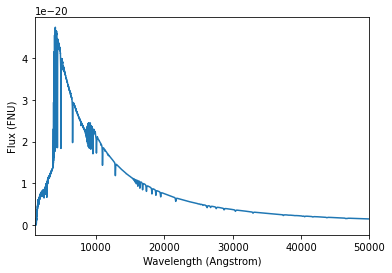

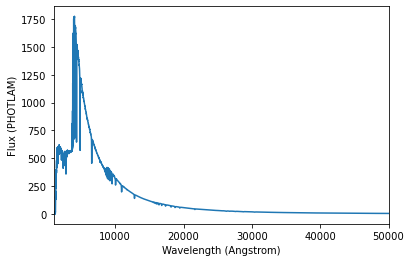

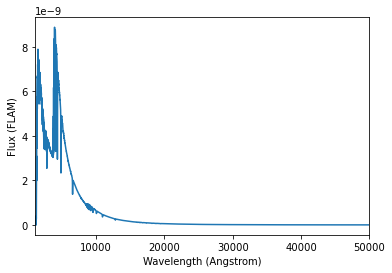

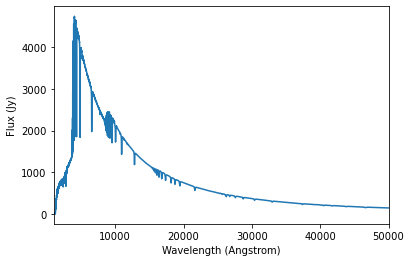

In [6]:

#... in photlam, the default for SourceSpectrum
print("from the original file")
print(max(vega(vega.waveset)))
#Plot using the SourceSpectrum.plot method, but specifying different 
vega.plot(left=1000,right=50000,flux_unit='fnu')
vega.plot(left=1000,right=50000,flux_unit='photlam')
vega.plot(left=1000,right=50000,flux_unit='flam')
vega.plot(left=1000,right=50000,flux_unit='Jy')#you can see this is

#However, you may want to work in different units, not just .plot in th
#The problem is that you cannot have a nice SourceSpectum object that i
#Something like
#> vega_flam = vega(vega.waveset,flux_units = units.FLAM)
#> print(max(vega_flam))
#could work, but still returns PHOTLAM.

#Hence here is how one can do it.
#First, convert the flux *arrays* from photlam to fnu, flam, fJy
vega_fnu=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit = units.FNU)
vega_flam=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit = units.FLAM)
vega_Jy=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit = u.Jy)
                           
#check:
print("\n from converted fluxes")
print(max(vega_fnu))
print(max(vega_flam))
print(max(vega_Jy))
#ok
                           
#then rebuild the spectra with these these values
vega_fnu=SourceSpectrum(Empirical1D,points=vega.waveset,lookup_table=vega_fnu)
vega_flam=SourceSpectrum(Empirical1D,points=vega.waveset,lookup_table=vega_flam)
vega_Jy=SourceSpectrum(Empirical1D,points=vega.waveset,lookup_table=vega_Jy)
                       
# finally create synphot spectra that have the right flux units.
vega_fnu=vega_fnu(vega.waveset,flux_unit=units.FNU)
vega_flam=vega_flam(vega.waveset,flux_unit=units.FLAM)
vega_Jy=vega_Jy(vega.waveset,flux_unit=u.Jy)
#check:
print("\n from the rebuilt spectra")
print(max(vega_fnu))
print(max(vega_flam))
print(max(vega_Jy))
                       
#Note, however, they are not "SourceSpectrum" objects. 

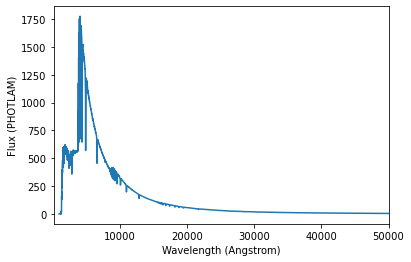

In [7]:
vega.plot(left=100,right=50000)

In [8]:
from os import listdir
"""
filters_directory=#cwd+"/nircam_throughputs/modA/nrc_plus_ote"
files_dir=listdir(filters_directory)
filter_file=[]
filters=[]
for names in files_dir:
    if names.endswith("sorted.txt"):
        filter_file.append(names)
        names = names[0:6]
        if names[5] == "_":
            names = names[0:5]
        filters.append(names[0:6])
print(filter_file,filters)
"""


filters_directory = cwd+"/scorpio_throughputs"
files_dir=listdir(filters_directory)
filter_file=[]
filters=[]
for names in files_dir:
    if names.endswith("txt"):
        filter_file.append(names)
        names = names[:-4]
        
        filters.append(names)
    
print(filter_file,filters)

['SCORPIO_r.txt', 'SCORPIO_g.txt', 'SCORPIO_J_no_adc.txt', 'SCORPIO_g_no_adc.txt', 'SCORPIO_Y_no_adc.txt', 'SCORPIO_H_no_adc.txt', 'SCORPIO_K_no_adc.txt', 'SCORPIO_z.txt', 'SCORPIO_i_no_adc.txt', 'SCORPIO_z_no_adc.txt', 'SCORPIO_Y.txt', 'SCORPIO_J.txt', 'SCORPIO_K.txt', 'SCORPIO_i.txt', 'SCORPIO_r_no_adc.txt', 'SCORPIO_H.txt'] ['SCORPIO_r', 'SCORPIO_g', 'SCORPIO_J_no_adc', 'SCORPIO_g_no_adc', 'SCORPIO_Y_no_adc', 'SCORPIO_H_no_adc', 'SCORPIO_K_no_adc', 'SCORPIO_z', 'SCORPIO_i_no_adc', 'SCORPIO_z_no_adc', 'SCORPIO_Y', 'SCORPIO_J', 'SCORPIO_K', 'SCORPIO_i', 'SCORPIO_r_no_adc', 'SCORPIO_H']


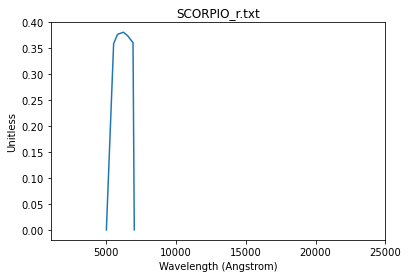

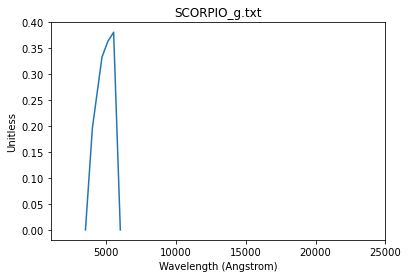

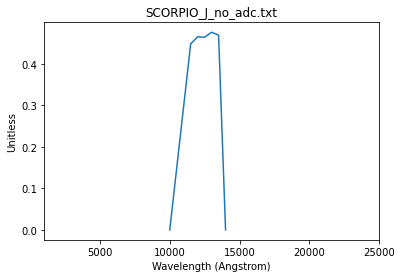

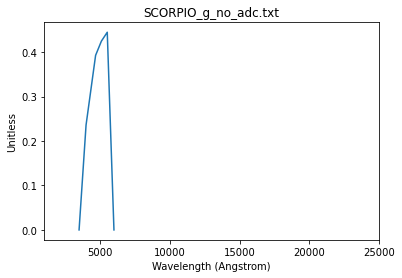

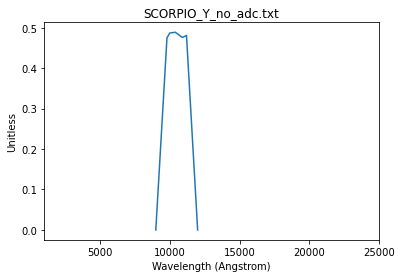

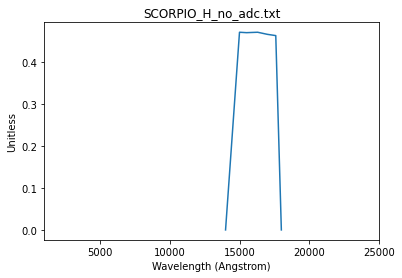

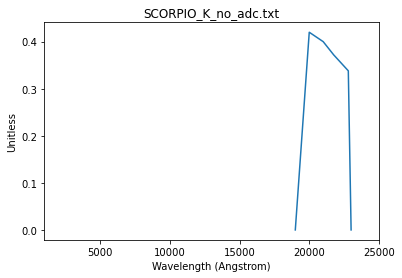

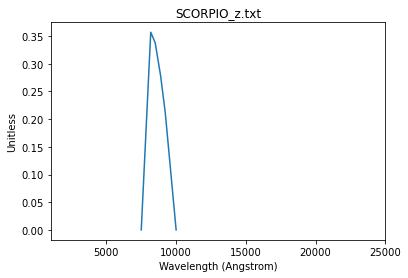

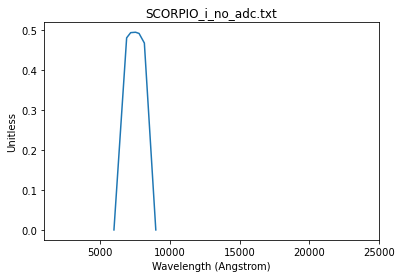

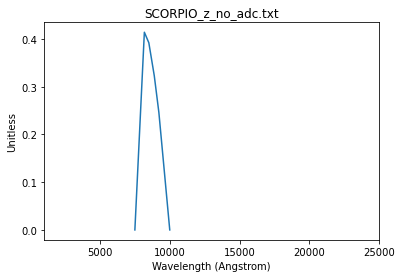

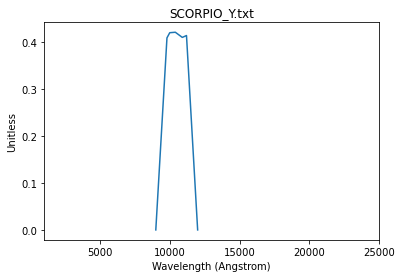

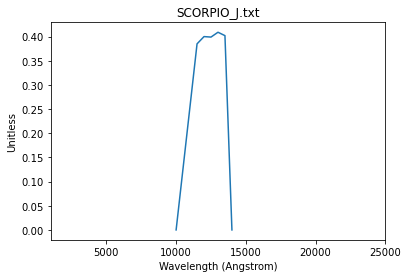

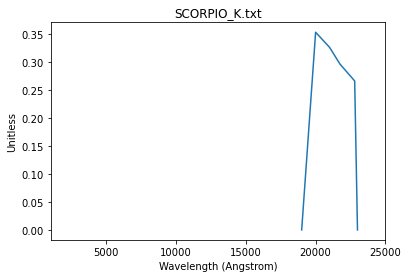

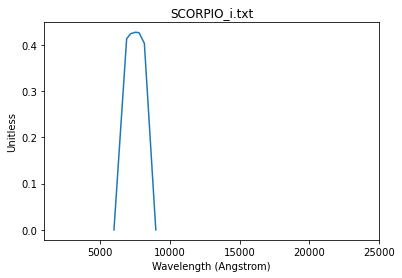

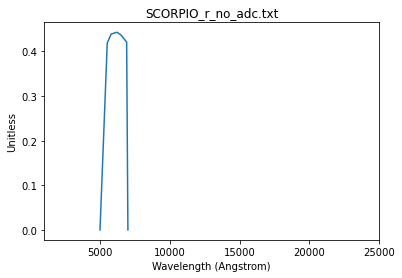

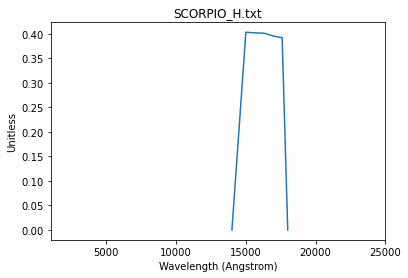

In [9]:
d =[]#used later for Pandas table
for i in range(len(filters)):
    bp=SpectralElement.from_file(filters_directory+'/'+filter_file[i])
    
    #convoluted way to change the wl units from nm to A
    wl=bp.waveset*1E1
    

    th = bp.model.lookup_table
    Filter=SpectralElement(Empirical1D,points=wl,lookup_table=th,keep_neg=True)
                           
    Filter.plot(left=1000, right=25000,title=filter_file[i])
    binset=range(1000,50001)
                                           
    obs_vega_Filter=Observation(vega,Filter,binset=binset)
    binflux=obs_vega_Filter.sample_binned(flux_unit='count',area=area)
    #print('binflux = ',binflux)
    
    # Sample the "native" flux for comparison                                                                                     
    flux_Vega=obs_vega_Filter(binset,flux_unit='count',area=area)
    flux_Vega_sum=flux_Vega.sum()
    #print('flux_Vega_sum = ',flux_Vega_sum)  
    #print('flux_Vega count rate = ', obs_vega_Filter.countrate(area).value) 
    #print('counts diffs = ', flux_Vega_sum.value/obs_vega_Filter.countrate(area).value)
    #print(obs_vega_Filter.effstim(flux_unit=units.VEGAMAG,vegaspec=vega))
    # Prepare Pandas table
    d.append((filters[i],np.round(flux_Vega_sum,2),
              np.round(obs_vega_Filter.effstim(u.ABmag),3),
              np.round(obs_vega_Filter.pivot(None),2),
              np.round(obs_vega_Filter.effective_wavelength(None),2)))
                                                       
#Create Pandas table, out of the loop
obs_vega_Filter_table=pd.DataFrame(d,columns=('Filter','Counts_s-1','VegaMag','pivot_wl', 'effective_wl'))            
                                     

# Column Defs

### Filter name

### Counts/s : predicted count rate for the telescope area through the given filter

### VegaMag : predicted Vega magnitude through the given filter (Vega spectrum is in ABmag units)

### pivot_wl : pivot wavelength to allow exact conversion between flux densities $F_{\nu}(R)$ and $F_{\lambda}(R)$ (source-independent)

### effective_wl : effective wavelength or the mean wavelength of detected photons (source-dependent)


## $\mathrm{vegamag} = -2.5 \mathrm{log_{10}} \frac{f}{f(VEGA)}$ 

## $\mathrm{ABmag} = -2.5 \mathrm{log_{10}} \frac{f_{\nu}}{3631 \ \mathrm{Jy}} $, unit is FNU

In [10]:
fnu_fl = obs_vega_Filter.effstim(flux_unit=units.FNU).to(u.Jy)
print(-2.5*np.log10(fnu_fl/(3631*u.Jy)))
obs_vega_Filter_table

1.3433644659508275


,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_r,127321582735.24 ct,0.113 mag(AB),5995.76 Angstrom,6016.26 Angstrom
1,SCORPIO_g,185946506340.48 ct,-0.055 mag(AB),4777.22 Angstrom,4809.11 Angstrom
2,SCORPIO_J_no_adc,69164898513.65 ct,0.871 mag(AB),12025.59 Angstrom,12061.8 Angstrom
3,SCORPIO_g_no_adc,219235515350.9 ct,-0.055 mag(AB),4772.7 Angstrom,4804.65 Angstrom
4,SCORPIO_Y_no_adc,75921266937.54 ct,0.653 mag(AB),10379.9 Angstrom,10401.4 Angstrom
5,SCORPIO_H_no_adc,38110435503.01 ct,1.344 mag(AB),15956.42 Angstrom,15986.34 Angstrom
6,SCORPIO_K_no_adc,16088419180.47 ct,1.812 mag(AB),20966.81 Angstrom,20990.13 Angstrom
7,SCORPIO_z,52000156565.1 ct,0.496 mag(AB),8559.84 Angstrom,8576.24 Angstrom
8,SCORPIO_i_no_adc,136047753322.28 ct,0.354 mag(AB),7364.17 Angstrom,7393.45 Angstrom
9,SCORPIO_z_no_adc,60332726862.12 ct,0.496 mag(AB),8560.04 Angstrom,8576.44 Angstrom


## Make sure XSHOOTER data are compatible

In [11]:
xshooters = "XSHOOTERStandards/all_xshooters.fits"
modfile = "XSHOOTERStandards/modL97-3.fits"

xhdus = fits.open(xshooters)
modhdus = fits.open(modfile)

xdhdu = xhdus[1]
modhdu = modhdus[1]

print(xdhdu.header['TUNIT1'])
print(xdhdu.header['TUNIT2'])

funit = xdhdu.header['TUNIT2']

flunit = 10*u.mW*u.m**(-2)*u.nm**(-1)
new_flunit = u.erg*u.s**(-1)*u.cm**(-2)*u.angstrom**(-1)


gd71_data = (xdhdu.data['GD71']*flunit).to(new_flunit)
LTT3218_data = (xdhdu.data['LTT3218']*flunit).to(new_flunit)
GD153_data = (xdhdu.data['GD153']*flunit).to(new_flunit)
EG274_data = (xdhdu.data['EG274']*flunit).to(new_flunit)
LTT7987_data = (xdhdu.data['LTT7987']*flunit).to(new_flunit)
Feige110_data = (xdhdu.data['Feige110']*flunit).to(new_flunit)
L97_data = (modhdu.data['L97-3']*flunit).to(new_flunit)


xdhdu.data['GD71'] = gd71_data
xdhdu.data['LTT3218'] = LTT3218_data
xdhdu.data['GD153'] = GD153_data
xdhdu.data['EG274'] = EG274_data
xdhdu.data['LTT7987'] = LTT7987_data
xdhdu.data['Feige110'] = Feige110_data
modhdu.data['L97-3'] = L97_data

xdhdu.data['lambda']

print(gd71_data)
gd71_data.to(new_flunit)


xlambda = fits.Column(name='WAVELENGTH',array=(xdhdu.data['lambda']*u.nm).to(u.angstrom),format='D')
x1 = fits.Column(name='FLUX',array=gd71_data,format='D')
x2 = fits.Column(name='FLUX',array=LTT3218_data,format='D')
x3 = fits.Column(name='FLUX',array=GD153_data,format='D')
x4 = fits.Column(name='FLUX',array=EG274_data,format='D')
x5 = fits.Column(name='FLUX',array=LTT7987_data,format='D')
x6 = fits.Column(name='FLUX',array=Feige110_data,format='D')
x7 = fits.Column(name='FLUX',array=L97_data,format='D')


def create_new_fits_bintab(lambda_col,flux_col,primary_hdu,err_col=None,new_fname=None):
    
    if err_col is not None:
        
        new_dhdu = fits.BinTableHDU.from_columns([lambda_col,flux_col,err_col])
        
    else:
        new_dhdu = fits.BinTableHDU.from_columns([lambda_col,flux_col])
    
    new_hdus = fits.HDUList([primary_hdu,new_dhdu])
    
    if new_fname is not None:
        
        new_hdus.writeto(new_fname,overwrite=True)
        
        
    return new_hdus    
    
gd71_hdul = create_new_fits_bintab(xlambda,x1,xhdus[0])

new_data_list = [x1,x2,x3,x4,x5,x6,x7]
new_fname_list = ["XSHOOTERStandards/GD71_spec.fits","XSHOOTERStandards/LTT3218_spec.fits","XSHOOTERStandards/GD153_spec.fits",
                  "XSHOOTERStandards/EG274_spec.fits","XSHOOTERStandards/LTT7987_spec.fits","XSHOOTERStandards/Feige110_spec.fits",
                  "XSHOOTERStandards/modL97-3_spec.fits"]

new_hdulists = []
for i in range(len(new_data_list)):
    
    new_flux = new_data_list[i]
    new_fname = new_fname_list[i]
    
    new_hdul = create_new_fits_bintab(lambda_col=xlambda,flux_col=new_flux,
                                      primary_hdu=xhdus[0],new_fname=new_fname)
    
    new_hdulists.append(new_hdul)
    
    
    
gd71_hdul[1].data

nm
10mW/m2/nm
[1.68217e-13 1.68197e-13 1.68178e-13 ... 6.26263e-17 6.26245e-17
 6.26226e-17] erg / (Angstrom cm2 s)


FITS_rec([( 3000.05, 1.68217e-13), ( 3000.15, 1.68197e-13),
          ( 3000.25, 1.68178e-13), ..., (24999.6 , 6.26263e-17),
          (24999.8 , 6.26245e-17), (25000.  , 6.26226e-17)],
         dtype=(numpy.record, [('WAVELENGTH', '<f8'), ('FLUX', '<f8')]))

# GD71 

## Spectral Type: DA
## $T_{eff}$ = 33950 K


[5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
733008.9474568953 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
1338044.899194066 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
226306.30273912207 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
1579881.3219013314 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
264799.20319712406 ct
[14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
112688.51916732923 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
43076.923486745494 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
225378.76432704882 ct
[6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
675765.8001013575 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
261484.58468671443 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
228048.59367672523 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
194466.6057982926 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
35168.388175978995 ct
[6000.

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_r,733008.95 ct,13.099,5964.92 Angstrom,5985.29 Angstrom
1,SCORPIO_g,1338044.9 ct,12.857,4677.32 Angstrom,4713.19 Angstrom
2,SCORPIO_J_no_adc,226306.3 ct,13.713,11997.3 Angstrom,12033.55 Angstrom
3,SCORPIO_g_no_adc,1579881.32 ct,12.856,4672.27 Angstrom,4708.18 Angstrom
4,SCORPIO_Y_no_adc,264799.2 ct,13.644,10357.11 Angstrom,10378.7 Angstrom
5,SCORPIO_H_no_adc,112688.52 ct,13.823,15929.77 Angstrom,15959.46 Angstrom
6,SCORPIO_K_no_adc,43076.92 ct,13.931,20955.74 Angstrom,20979.08 Angstrom
7,SCORPIO_z,225378.76 ct,13.408,8515.21 Angstrom,8530.93 Angstrom
8,SCORPIO_i_no_adc,675765.8 ct,13.26,7323.31 Angstrom,7352.31 Angstrom
9,SCORPIO_z_no_adc,261484.58 ct,13.408,8515.41 Angstrom,8531.13 Angstrom


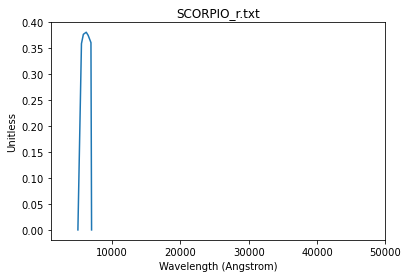

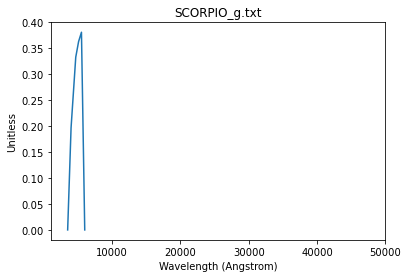

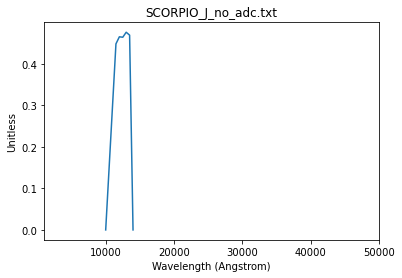

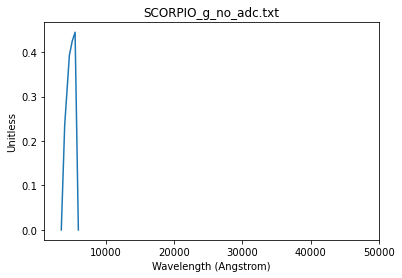

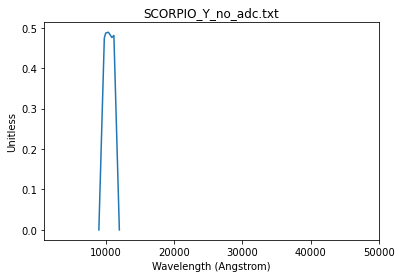

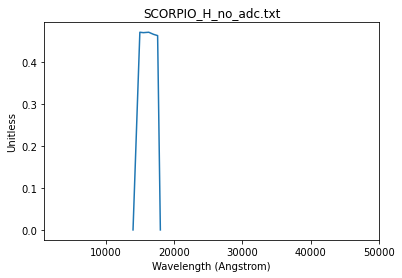

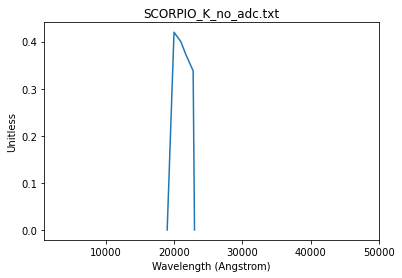

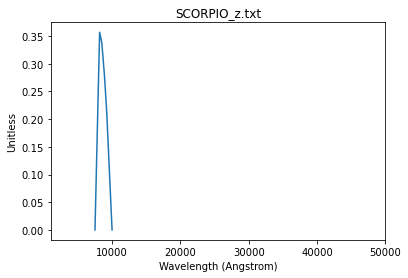

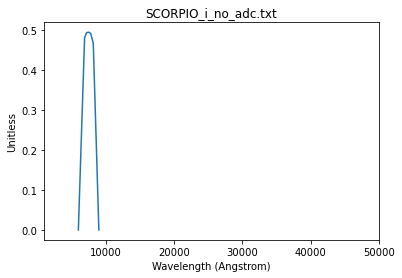

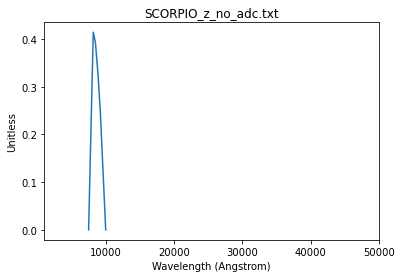

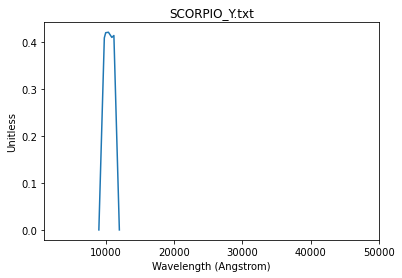

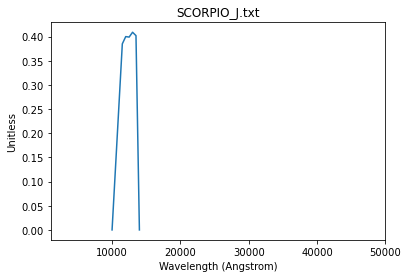

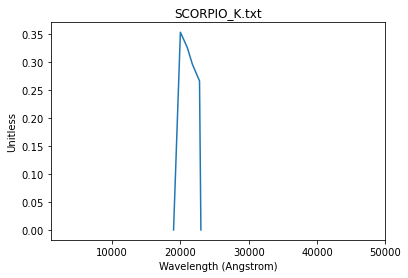

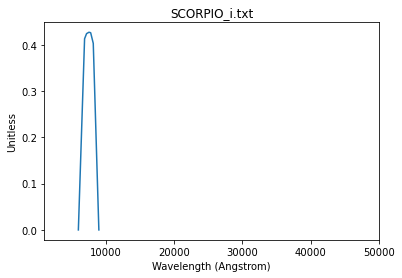

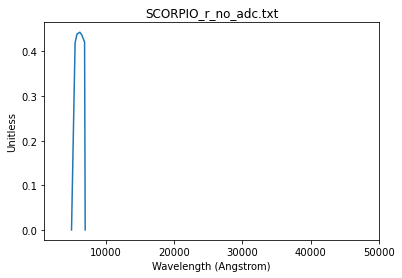

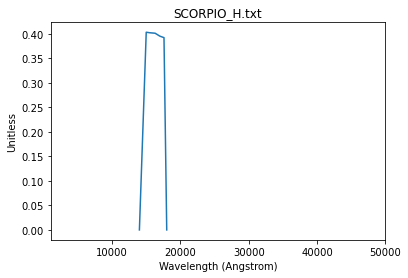

In [12]:
sp_GD71=SourceSpectrum.from_file(new_fname_list[0],flux_unit='flam')

GD71_table = get_synphot_table(filters=filters,filter_file=filter_file,filters_dir=filters_directory,
                              sp_STD=sp_GD71,vega=vega,area=area,filter_plot=True)

GD71_table

from the original file
0.025405143011263277 PHOTLAM

 from converted fluxes
5.050171961032261e-25 FNU
1.68217e-13 FLAM
0.05050171961032261 Jy

 from the rebuilt spectra
5.0501719610322605e-25 FNU
1.68217e-13 FLAM
0.0505017196103226 Jy


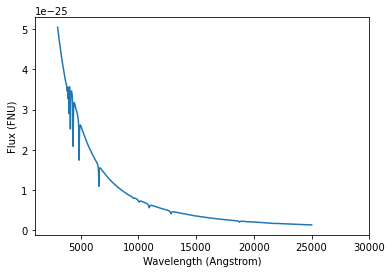

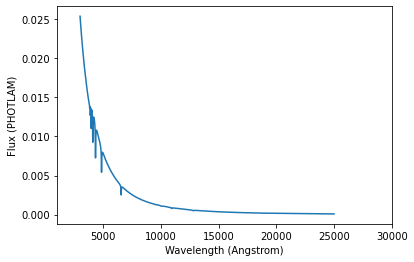

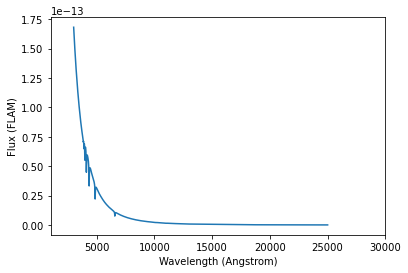

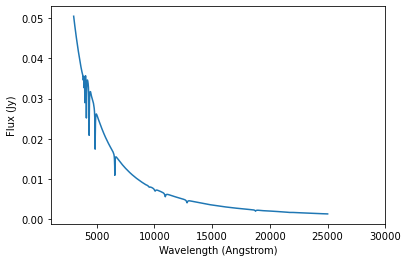

In [13]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_GD71(sp_GD71.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_GD71.plot(left=1000,right=30000,flux_unit='fnu')
sp_GD71.plot(left=1000,right=30000,flux_unit='photlam')
sp_GD71.plot(left=1000,right=30000,flux_unit='flam')
sp_GD71.plot(left=1000,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_GD71_fnu=units.convert_flux(sp_GD71.waveset,fluxes=sp_GD71(sp_GD71.waveset),out_flux_unit = units.FNU)
sp_GD71_flam=units.convert_flux(sp_GD71.waveset,fluxes=sp_GD71(sp_GD71.waveset),out_flux_unit = units.FLAM)
sp_GD71_Jy=units.convert_flux(sp_GD71.waveset,fluxes=sp_GD71(sp_GD71.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_GD71_fnu))
print(max(sp_GD71_flam))
print(max(sp_GD71_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_GD71_fnu=SourceSpectrum(Empirical1D,points=sp_GD71.waveset,lookup_table=sp_GD71_fnu)
sp_GD71_flam=SourceSpectrum(Empirical1D,points=sp_GD71.waveset,lookup_table=sp_GD71_flam)
sp_GD71_Jy=SourceSpectrum(Empirical1D,points=sp_GD71.waveset,lookup_table=sp_GD71_Jy)

# and create synphot spectra that have the right flux units.
sp_GD71_fnu=sp_GD71_fnu(sp_GD71.waveset,flux_unit=units.FNU)
sp_GD71_flam=sp_GD71_flam(sp_GD71.waveset,flux_unit=units.FLAM)
sp_GD71_Jy=sp_GD71_Jy(sp_GD71.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good p
#these objects, pretty bad.
#check:
print("\n from the rebuilt spectra")
print(max(sp_GD71_fnu))
print(max(sp_GD71_flam))
print(max(sp_GD71_Jy))

# LTT3218

## Spectral Type: DA
## $T_{eff}$ = 9081 K

In [14]:
sp_LTT3218=SourceSpectrum.from_file(new_fname_list[1],flux_unit='flam')

LTT3218_table = get_synphot_table(filters=filters,filter_file=filter_file,filters_dir=filters_directory,
                              sp_STD=sp_LTT3218,vega=vega,area=area,filter_plot=False)



LTT3218_table

[5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
2485865.432024861 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
3104290.29416274 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
1553851.9049651038 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
3657837.4817106235 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
1618980.6683828908 ct
[14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
925545.8438852159 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
381331.38236790325 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
1156836.1293631461 ct
[6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
2956240.595071952 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
1342192.3697705872 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
1394270.635482548 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
1335199.022132166 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
311264.6485522958 ct
[6000. 691

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_r,2485865.43 ct,11.774,6017.27 Angstrom,6037.72 Angstrom
1,SCORPIO_g,3104290.29 ct,11.944,4814.83 Angstrom,4848.4 Angstrom
2,SCORPIO_J_no_adc,1553851.9 ct,11.621,12050.34 Angstrom,12086.44 Angstrom
3,SCORPIO_g_no_adc,3657837.48 ct,11.944,4810.2 Angstrom,4843.86 Angstrom
4,SCORPIO_Y_no_adc,1618980.67 ct,11.678,10393.47 Angstrom,10415.2 Angstrom
5,SCORPIO_H_no_adc,925545.84 ct,11.537,15954.1 Angstrom,15983.76 Angstrom
6,SCORPIO_K_no_adc,381331.38 ct,11.563,20964.97 Angstrom,20988.33 Angstrom
7,SCORPIO_z,1156836.13 ct,11.632,8545.51 Angstrom,8561.5 Angstrom
8,SCORPIO_i_no_adc,2956240.6 ct,11.657,7391.51 Angstrom,7420.55 Angstrom
9,SCORPIO_z_no_adc,1342192.37 ct,11.632,8545.71 Angstrom,8561.69 Angstrom


from the original file
0.024093937336753555 PHOTLAM

 from converted fluxes
6.927717103806033e-25 FNU
1.2785e-13 FLAM
0.06927717103806032 Jy

 from the rebuilt spectra
6.927717103806034e-25 FNU
1.2785e-13 FLAM
0.06927717103806032 Jy


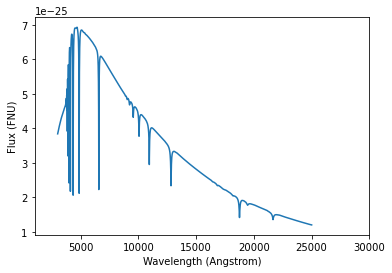

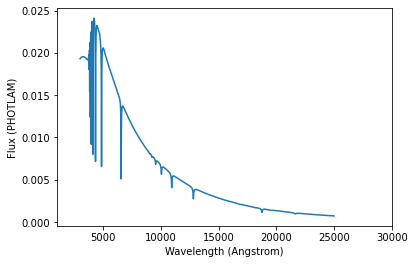

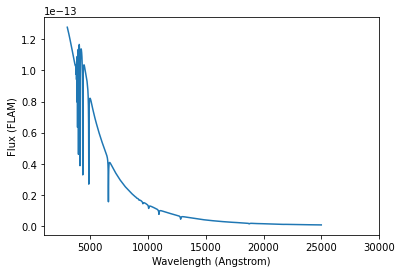

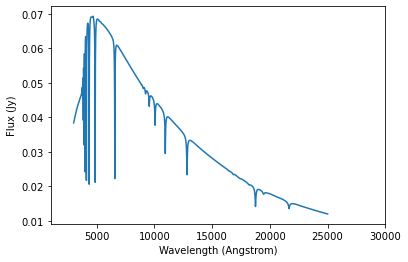

In [15]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_LTT3218(sp_LTT3218.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_LTT3218.plot(left=1000,right=30000,flux_unit='fnu')
sp_LTT3218.plot(left=1000,right=30000,flux_unit='photlam')
sp_LTT3218.plot(left=1000,right=30000,flux_unit='flam')
sp_LTT3218.plot(left=1000,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_LTT3218_fnu=units.convert_flux(sp_LTT3218.waveset,fluxes=sp_LTT3218(sp_LTT3218.waveset),out_flux_unit = units.FNU)
sp_LTT3218_flam=units.convert_flux(sp_LTT3218.waveset,fluxes=sp_LTT3218(sp_LTT3218.waveset),out_flux_unit = units.FLAM)
sp_LTT3218_Jy=units.convert_flux(sp_LTT3218.waveset,fluxes=sp_LTT3218(sp_LTT3218.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_LTT3218_fnu))
print(max(sp_LTT3218_flam))
print(max(sp_LTT3218_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_LTT3218_fnu=SourceSpectrum(Empirical1D,points=sp_LTT3218.waveset,lookup_table=sp_LTT3218_fnu)
sp_LTT3218_flam=SourceSpectrum(Empirical1D,points=sp_LTT3218.waveset,lookup_table=sp_LTT3218_flam)
sp_LTT3218_Jy=SourceSpectrum(Empirical1D,points=sp_LTT3218.waveset,lookup_table=sp_LTT3218_Jy)

# and create synphot spectra that have the right flux units.
sp_LTT3218_fnu=sp_LTT3218_fnu(sp_LTT3218.waveset,flux_unit=units.FNU)
sp_LTT3218_flam=sp_LTT3218_flam(sp_LTT3218.waveset,flux_unit=units.FLAM)
sp_LTT3218_Jy=sp_LTT3218_Jy(sp_LTT3218.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good p
#these objects, pretty bad.
#check:
print("\n from the rebuilt spectra")
print(max(sp_LTT3218_fnu))
print(max(sp_LTT3218_flam))
print(max(sp_LTT3218_Jy))

# GD153

## Spectral Type: DA
## $T_{eff}$ = 40320 K

In [16]:
sp_GD153=SourceSpectrum.from_file(new_fname_list[2],flux_unit='flam')

GD153_table = get_synphot_table(filters=filters,filter_file=filter_file,filters_dir=filters_directory,
                              sp_STD=sp_GD153,vega=vega,area=area,filter_plot=False)

GD153_table

[5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
550322.0300082756 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
1026362.509668591 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
166326.80252823158 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
1212079.9944831 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
195592.56297251655 ct
[14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
82696.44423565398 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
31480.285355634885 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
167321.60121443827 ct
[6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
504413.0201302358 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
194126.50660032744 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
168447.31429220628 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
142925.91603084767 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
25700.29370385831 ct
[6000. 691

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_r,550322.03 ct,13.411,5964.81 Angstrom,5985.2 Angstrom
1,SCORPIO_g,1026362.51 ct,13.145,4665.92 Angstrom,4702.04 Angstrom
2,SCORPIO_J_no_adc,166326.8 ct,14.047,11995.94 Angstrom,12032.21 Angstrom
3,SCORPIO_g_no_adc,1212079.99 ct,13.143,4660.84 Angstrom,4696.98 Angstrom
4,SCORPIO_Y_no_adc,195592.56 ct,13.973,10355.45 Angstrom,10377.02 Angstrom
5,SCORPIO_H_no_adc,82696.44 ct,14.159,15929.84 Angstrom,15959.5 Angstrom
6,SCORPIO_K_no_adc,31480.29 ct,14.271,20956.02 Angstrom,20979.37 Angstrom
7,SCORPIO_z,167321.6 ct,13.731,8514.41 Angstrom,8530.12 Angstrom
8,SCORPIO_i_no_adc,504413.02 ct,13.577,7320.53 Angstrom,7349.54 Angstrom
9,SCORPIO_z_no_adc,194126.51 ct,13.731,8514.61 Angstrom,8530.32 Angstrom


from the original file
0.02077725286166995 PHOTLAM

 from converted fluxes
4.130214885338892e-25 FNU
1.37574e-13 FLAM
0.04130214885338892 Jy

 from the rebuilt spectra
4.130214885338892e-25 FNU
1.37574e-13 FLAM
0.041302148853388926 Jy


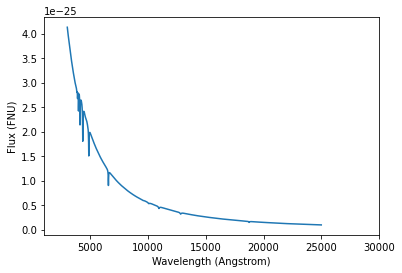

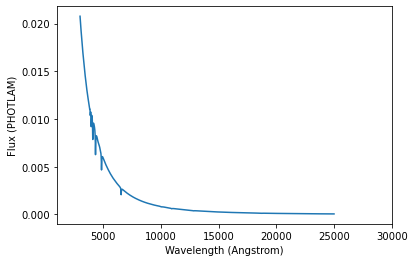

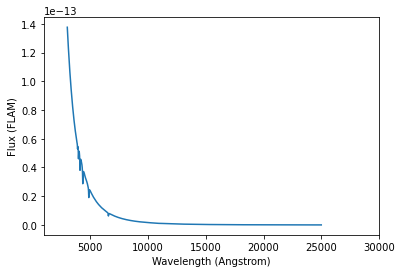

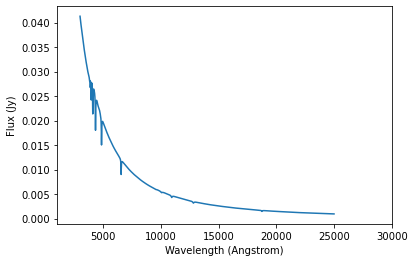

In [17]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_GD153(sp_GD153.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_GD153.plot(left=1000,right=30000,flux_unit='fnu')
sp_GD153.plot(left=1000,right=30000,flux_unit='photlam')
sp_GD153.plot(left=1000,right=30000,flux_unit='flam')
sp_GD153.plot(left=1000,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_GD153_fnu=units.convert_flux(sp_GD153.waveset,fluxes=sp_GD153(sp_GD153.waveset),out_flux_unit = units.FNU)
sp_GD153_flam=units.convert_flux(sp_GD153.waveset,fluxes=sp_GD153(sp_GD153.waveset),out_flux_unit = units.FLAM)
sp_GD153_Jy=units.convert_flux(sp_GD153.waveset,fluxes=sp_GD153(sp_GD153.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_GD153_fnu))
print(max(sp_GD153_flam))
print(max(sp_GD153_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_GD153_fnu=SourceSpectrum(Empirical1D,points=sp_GD153.waveset,lookup_table=sp_GD153_fnu)
sp_GD153_flam=SourceSpectrum(Empirical1D,points=sp_GD153.waveset,lookup_table=sp_GD153_flam)
sp_GD153_Jy=SourceSpectrum(Empirical1D,points=sp_GD153.waveset,lookup_table=sp_GD153_Jy)

# and create synphot spectra that have the right flux units.
sp_GD153_fnu=sp_GD153_fnu(sp_GD153.waveset,flux_unit=units.FNU)
sp_GD153_flam=sp_GD153_flam(sp_GD153.waveset,flux_unit=units.FLAM)
sp_GD153_Jy=sp_GD153_Jy(sp_GD153.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good p
#these objects, pretty bad.
#check:
print("\n from the rebuilt spectra")
print(max(sp_GD153_fnu))
print(max(sp_GD153_flam))
print(max(sp_GD153_Jy))

# EG274

## Spectral Type: DA
## $T_{eff}$ = 25985 K

In [18]:
sp_EG274=SourceSpectrum.from_file(new_fname_list[3],flux_unit='flam')

EG274_table = get_synphot_table(filters=filters,filter_file=filter_file,filters_dir=filters_directory,
                              sp_STD=sp_EG274,vega=vega,area=area,filter_plot=False)



[5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
4677082.861989785 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
8125599.1058474835 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
1551391.8397969992 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
9589943.30730542 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
1786238.2206525824 ct
[14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
787949.0098049222 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
304462.1895371544 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
1487959.0638071385 ct
[6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
4390328.27766584 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
1726334.2925799207 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
1538324.7801671508 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
1333118.3664046056 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
248563.77620384004 ct
[6000. 69

from the original file
0.12707087183452767 PHOTLAM

 from converted fluxes
2.5259836314172577e-24 FNU
8.413839999999999e-13 FLAM
0.25259836314172573 Jy

 from the rebuilt spectra
2.5259836314172577e-24 FNU
8.413839999999999e-13 FLAM
0.25259836314172573 Jy


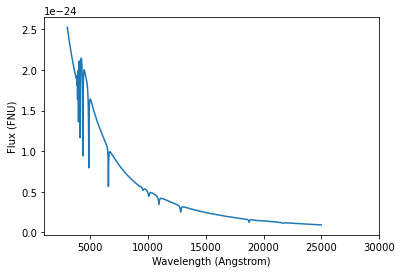

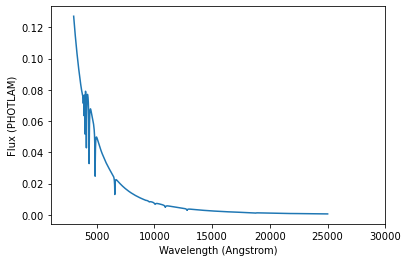

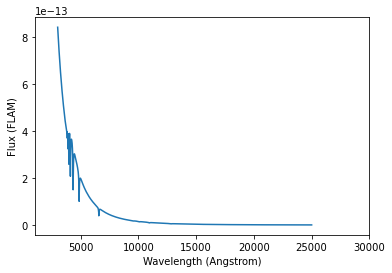

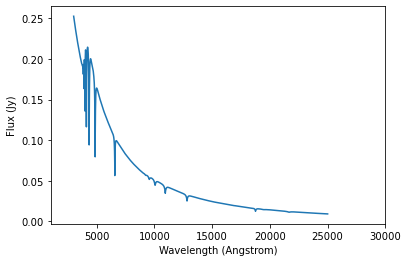

In [19]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_EG274(sp_EG274.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_EG274.plot(left=1000,right=30000,flux_unit='fnu')
sp_EG274.plot(left=1000,right=30000,flux_unit='photlam')
sp_EG274.plot(left=1000,right=30000,flux_unit='flam')
sp_EG274.plot(left=1000,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_EG274_fnu=units.convert_flux(sp_EG274.waveset,fluxes=sp_EG274(sp_EG274.waveset),out_flux_unit = units.FNU)
sp_EG274_flam=units.convert_flux(sp_EG274.waveset,fluxes=sp_EG274(sp_EG274.waveset),out_flux_unit = units.FLAM)
sp_EG274_Jy=units.convert_flux(sp_EG274.waveset,fluxes=sp_EG274(sp_EG274.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_EG274_fnu))
print(max(sp_EG274_flam))
print(max(sp_EG274_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_EG274_fnu=SourceSpectrum(Empirical1D,points=sp_EG274.waveset,lookup_table=sp_EG274_fnu)
sp_EG274_flam=SourceSpectrum(Empirical1D,points=sp_EG274.waveset,lookup_table=sp_EG274_flam)
sp_EG274_Jy=SourceSpectrum(Empirical1D,points=sp_EG274.waveset,lookup_table=sp_EG274_Jy)

# and create synphot spectra that have the right flux units.
sp_EG274_fnu=sp_EG274_fnu(sp_EG274.waveset,flux_unit=units.FNU)
sp_EG274_flam=sp_EG274_flam(sp_EG274.waveset,flux_unit=units.FLAM)
sp_EG274_Jy=sp_EG274_Jy(sp_EG274.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good p
#these objects, pretty bad.
#check:
print("\n from the rebuilt spectra")
print(max(sp_EG274_fnu))
print(max(sp_EG274_flam))
print(max(sp_EG274_Jy))

# LTT7987

## Spectral Type: DA
## $T_{eff}$ = 16147 K

In [20]:
sp_LTT7987=SourceSpectrum.from_file(new_fname_list[4],flux_unit='flam')

LTT7987_table = get_synphot_table(filters=filters,filter_file=filter_file,filters_dir=filters_directory,
                              sp_STD=sp_LTT7987,vega=vega,area=area,filter_plot=False)



[5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
1581941.2079516065 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
2433481.862123066 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
626520.8917551233 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
2869356.182641153 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
696046.5255169675 ct
[14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
340746.72046213783 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
132511.26939652386 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
549336.2536037856 ct
[6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
1561172.1375987607 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
637344.1638410289 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
599437.1512420295 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
538369.0301349967 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
108172.31261369814 ct
[6000. 691

from the original file
0.023592981868262582 PHOTLAM

 from converted fluxes
6.385051678659892e-25 FNU
1.5621800000000002e-13 FLAM
0.06385051678659891 Jy

 from the rebuilt spectra
6.385051678659892e-25 FNU
1.5621800000000002e-13 FLAM
0.06385051678659891 Jy


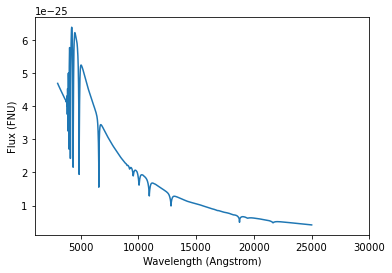

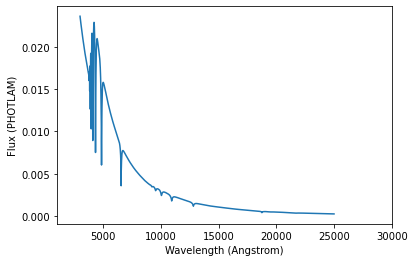

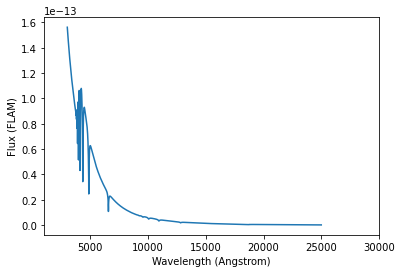

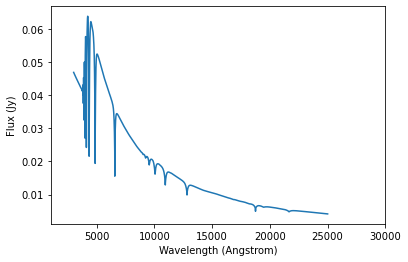

In [21]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_LTT7987(sp_LTT7987.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_LTT7987.plot(left=1000,right=30000,flux_unit='fnu')
sp_LTT7987.plot(left=1000,right=30000,flux_unit='photlam')
sp_LTT7987.plot(left=1000,right=30000,flux_unit='flam')
sp_LTT7987.plot(left=1000,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_LTT7987_fnu=units.convert_flux(sp_LTT7987.waveset,fluxes=sp_LTT7987(sp_LTT7987.waveset),out_flux_unit = units.FNU)
sp_LTT7987_flam=units.convert_flux(sp_LTT7987.waveset,fluxes=sp_LTT7987(sp_LTT7987.waveset),out_flux_unit = units.FLAM)
sp_LTT7987_Jy=units.convert_flux(sp_LTT7987.waveset,fluxes=sp_LTT7987(sp_LTT7987.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_LTT7987_fnu))
print(max(sp_LTT7987_flam))
print(max(sp_LTT7987_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_LTT7987_fnu=SourceSpectrum(Empirical1D,points=sp_LTT7987.waveset,lookup_table=sp_LTT7987_fnu)
sp_LTT7987_flam=SourceSpectrum(Empirical1D,points=sp_LTT7987.waveset,lookup_table=sp_LTT7987_flam)
sp_LTT7987_Jy=SourceSpectrum(Empirical1D,points=sp_LTT7987.waveset,lookup_table=sp_LTT7987_Jy)

# and create synphot spectra that have the right flux units.
sp_LTT7987_fnu=sp_LTT7987_fnu(sp_LTT7987.waveset,flux_unit=units.FNU)
sp_LTT7987_flam=sp_LTT7987_flam(sp_LTT7987.waveset,flux_unit=units.FLAM)
sp_LTT7987_Jy=sp_LTT7987_Jy(sp_LTT7987.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" 
#check:
print("\n from the rebuilt spectra")
print(max(sp_LTT7987_fnu))
print(max(sp_LTT7987_flam))
print(max(sp_LTT7987_Jy))

# Feige110 

## Spectral Type: sdO
## $T_{eff}$ = 45250 K

In [22]:
sp_Feige110=SourceSpectrum.from_file(new_fname_list[5],flux_unit='flam')



Feige110_table = get_synphot_table(filters=filters,filter_file=filter_file,filters_dir=filters_directory,
                              sp_STD=sp_Feige110,vega=vega,area=area,filter_plot=False)

Feige110_table

[5000. 5520. 5800. 6220. 6500. 6910. 7000.] Angstrom
2284007.7390563423 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
4332857.541195534 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
696718.4382934296 ct
[3500. 4000. 4685. 5100. 5520. 6000.] Angstrom
5117658.8807803895 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
818085.2015103643 ct
[14000. 15000. 15500. 16300. 17000. 17600. 18000.] Angstrom
345541.7903792287 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
132947.57970519824 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
696747.7672393995 ct
[6000. 6910. 7200. 7550. 7800. 8180. 9000.] Angstrom
2099715.162783437 ct
[ 7500.  8180.  8500.  8890.  9220. 10000.] Angstrom
808367.4735934151 ct
[ 9000.  9800. 10000. 10400. 10900. 11200. 12000.] Angstrom
704547.8234398455 ct
[10000. 11500. 12000. 12500. 13000. 13500. 14000.] Angstrom
598695.4823610866 ct
[19000. 20000. 21000. 21750. 22800. 23000.] Angstrom
108533.1887690503 ct
[6000. 6910.

,Filter,Counts_s-1,VegaMag,pivot_wl,effective_wl
0,SCORPIO_r,2284007.74 ct,11.866,5967.39 Angstrom,5987.81 Angstrom
1,SCORPIO_g,4332857.54 ct,11.582,4656.49 Angstrom,4692.56 Angstrom
2,SCORPIO_J_no_adc,696718.44 ct,12.492,11997.28 Angstrom,12033.59 Angstrom
3,SCORPIO_g_no_adc,5117658.88 ct,11.58,4651.41 Angstrom,4687.49 Angstrom
4,SCORPIO_Y_no_adc,818085.2 ct,12.419,10356.06 Angstrom,10377.59 Angstrom
5,SCORPIO_H_no_adc,345541.79 ct,12.606,15931.2 Angstrom,15960.89 Angstrom
6,SCORPIO_K_no_adc,132947.58 ct,12.707,20957.46 Angstrom,20980.79 Angstrom
7,SCORPIO_z,696747.77 ct,12.182,8515.3 Angstrom,8531.02 Angstrom
8,SCORPIO_i_no_adc,2099715.16 ct,12.029,7319.3 Angstrom,7348.36 Angstrom
9,SCORPIO_z_no_adc,808367.47 ct,12.182,8515.5 Angstrom,8531.22 Angstrom


from the original file
0.08897924158813277 PHOTLAM

 from converted fluxes
1.768777569105128e-24 FNU
5.89165e-13 FLAM
0.17687775691051277 Jy

 from the rebuilt spectra
1.768777569105128e-24 FNU
5.89165e-13 FLAM
0.17687775691051277 Jy


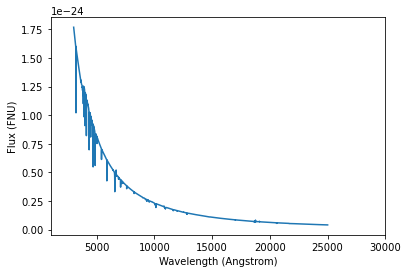

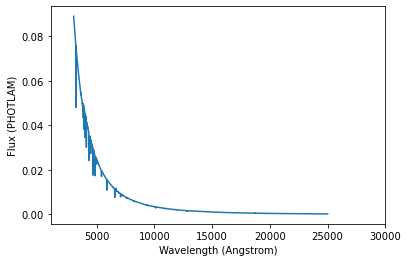

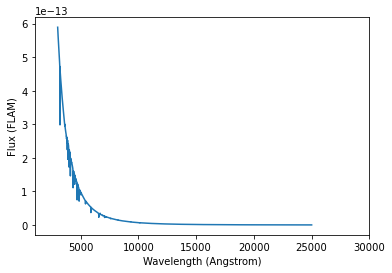

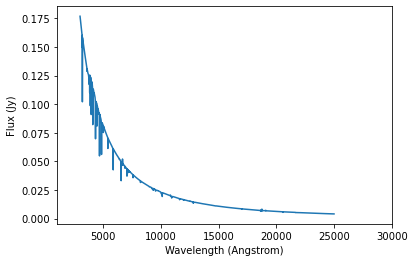

In [23]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_Feige110(sp_Feige110.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_Feige110.plot(left=1000,right=30000,flux_unit='fnu')
sp_Feige110.plot(left=1000,right=30000,flux_unit='photlam')
sp_Feige110.plot(left=1000,right=30000,flux_unit='flam')
sp_Feige110.plot(left=1000,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_Feige110_fnu=units.convert_flux(sp_Feige110.waveset,fluxes=sp_Feige110(sp_Feige110.waveset),out_flux_unit = units.FNU)
sp_Feige110_flam=units.convert_flux(sp_Feige110.waveset,fluxes=sp_Feige110(sp_Feige110.waveset),out_flux_unit = units.FLAM)
sp_Feige110_Jy=units.convert_flux(sp_Feige110.waveset,fluxes=sp_Feige110(sp_Feige110.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_Feige110_fnu))
print(max(sp_Feige110_flam))
print(max(sp_Feige110_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_Feige110_fnu=SourceSpectrum(Empirical1D,points=sp_Feige110.waveset,lookup_table=sp_Feige110_fnu)
sp_Feige110_flam=SourceSpectrum(Empirical1D,points=sp_Feige110.waveset,lookup_table=sp_Feige110_flam)
sp_Feige110_Jy=SourceSpectrum(Empirical1D,points=sp_Feige110.waveset,lookup_table=sp_Feige110_Jy)

# and create synphot spectra that have the right flux units.
sp_Feige110_fnu=sp_Feige110_fnu(sp_Feige110.waveset,flux_unit=units.FNU)
sp_Feige110_flam=sp_Feige110_flam(sp_Feige110.waveset,flux_unit=units.FLAM)
sp_Feige110_Jy=sp_Feige110_Jy(sp_Feige110.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good p
#these objects, pretty bad.
#check:
print("\n from the rebuilt spectra")
print(max(sp_Feige110_fnu))
print(max(sp_Feige110_flam))
print(max(sp_Feige110_Jy))

1087487.358853602 ct / s
939876.4836301397 ct / s
1342984.9125328958 ct / s
1105418.7350962856 ct / s
1227392.5820277291 ct / s
1006385.5417635703 ct / s
446127.9960131667 ct / s
731044.2916108047 ct / s
1635497.5862476802 ct / s
848196.9280498077 ct / s
1057029.9560188567 ct / s
1153963.3339545208 ct / s
364082.98207503126 ct / s
1407890.0924666096 ct / s
1267043.8725542843 ct / s
857516.7376406797 ct / s


,Filter,Counts/s,VegaMag,piwot wl,effective wl
0,SCORPIO_r,1087487.39 ct,13.0,6083.23 Angstrom,6103.31 Angstrom
1,SCORPIO_g,939876.52 ct,13.0,4944.77 Angstrom,4973.98 Angstrom
2,SCORPIO_J_no_adc,1342984.91 ct,12.0,12119.41 Angstrom,12155.35 Angstrom
3,SCORPIO_g_no_adc,1105418.78 ct,13.0,4940.88 Angstrom,4970.21 Angstrom
4,SCORPIO_Y_no_adc,1227392.58 ct,12.0,10429.01 Angstrom,10450.67 Angstrom
5,SCORPIO_H_no_adc,1006385.54 ct,11.0,15992.32 Angstrom,16021.9 Angstrom
6,SCORPIO_K_no_adc,446127.99 ct,11.0,20971.21 Angstrom,20994.51 Angstrom
7,SCORPIO_z,731044.29 ct,12.0,8575.94 Angstrom,8592.21 Angstrom
8,SCORPIO_i_no_adc,1635497.59 ct,12.0,7443.17 Angstrom,7472.29 Angstrom
9,SCORPIO_z_no_adc,848196.93 ct,12.0,8576.14 Angstrom,8592.41 Angstrom


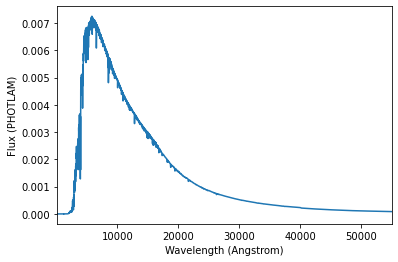

In [24]:
P330e_solar = "StandardStarsSpectra/solar_P330-E_spec.txt"

table=pd.read_table(P330e_solar,skiprows=1)#,skipinitialspace=True)



#extract...
wl=table['lambda(nm)']*10  # Angstrom
fl=table['photonsm-2nm-1']/1E4/10 #FROM u.photon / (u.cm**2 * u.s

sp_P330e_solar=SourceSpectrum(Empirical1D,points=wl.to_numpy(),lookup_table=fl)

sp_P330e_solar.plot(left=100,right=55000)

d = []#used later for Pandas table
for i in range(len(filters)):
    
    bp = SpectralElement.from_file(filters_directory+'/'+filter_file[i])
    bp.waveset.to(u.micron)
    #convoluted way to change the wl units from micron to A. There must
    wl = bp.waveset*1E1
    th = bp.model.lookup_table
    Filter = SpectralElement(Empirical1D,points=wl,lookup_table=th,keep_neg=True)
    #print(wl)              
    #Filter.plot(left=100, right=55000)
    area=25*1E4*units.AREA
    binset=range(1000,50001)
                           
    obs_P330e_solar_Filter=Observation(sp_P330e_solar,Filter,binset=binset,force='extrap')
    binflux=obs_P330e_solar_Filter.sample_binned(flux_unit='count',area=area)
    # Sample the "native" flux for comparison                                           
    flux=obs_P330e_solar_Filter(binset,flux_unit='count',area=area)
    flux_sum=flux.sum()
# print(flux_sum)
    print(obs_P330e_solar_Filter.countrate(area))                          
    obs_vega_Filter=Observation(vega,Filter,binset=binset)
    binflux=obs_vega_Filter.sample_binned(flux_unit='count',area=area)
    # Sample the "native" flux for comparison
    flux_Vega=obs_vega_Filter(binset,flux_unit='count',area=area)
    flux_Vega_sum=flux_Vega.sum()
                                          
    mag_P330e_solar_Filter=-2.5*np.log10(flux_sum/flux_Vega_sum)
    # print(filters[i],np.round(flux_sum,2),' VegaMag = ',np.round(mag_P

    #Other parameters
    # print("pivot wl:",np.round(obs_P330e_solar_Filter.pivot(),2)," effecti

    # Prepare Pandas table
    d.append((filters[i],np.round(flux_sum,2),np.round(mag_P330e_solar_Filter),
              np.round(obs_P330e_solar_Filter.pivot(),2),
              np.round(obs_P330e_solar_Filter.effective_wavelength(),2)))
                                                      
#Create Pandas table, out of the loop
P330e_solar_table=pd.DataFrame(d,columns=('Filter','Counts/s','VegaMag','piwot wl', 'effective wl'))
                                        

P330e_solar_table

from the original file
0.0072510000000000005 PHOTLAM

 from converted fluxes
3.31491952935066e-25 FNU
2.872638554395856e-14 FLAM
0.0331491952935066 Jy

 from the rebuilt spectra
3.31491952935066e-25 FNU
2.872638554395856e-14 FLAM
0.0331491952935066 Jy


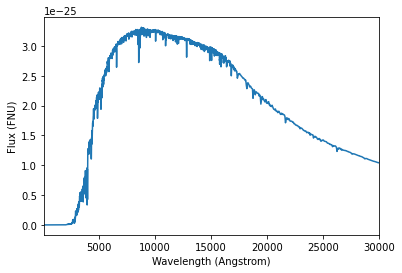

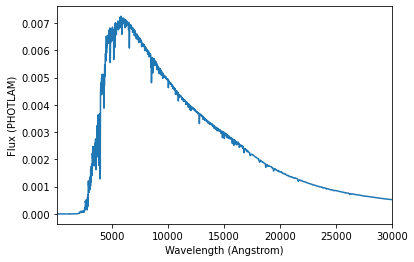

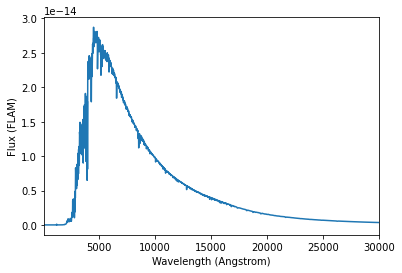

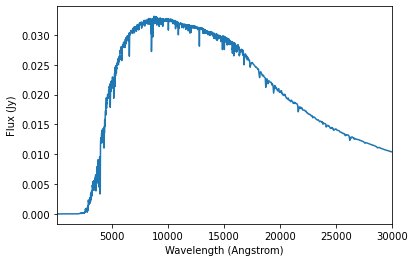

In [25]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_P330e_solar(sp_P330e_solar.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_P330e_solar.plot(left=100,right=30000,flux_unit='fnu')
sp_P330e_solar.plot(left=100,right=30000,flux_unit='photlam')
sp_P330e_solar.plot(left=100,right=30000,flux_unit='flam')
sp_P330e_solar.plot(left=100,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_P330e_solar_fnu=units.convert_flux(sp_P330e_solar.waveset,fluxes=sp_P330e_solar(sp_P330e_solar.waveset),out_flux_unit = units.FNU)
sp_P330e_solar_flam=units.convert_flux(sp_P330e_solar.waveset,fluxes=sp_P330e_solar(sp_P330e_solar.waveset),out_flux_unit = units.FLAM)
sp_P330e_solar_Jy=units.convert_flux(sp_P330e_solar.waveset,fluxes=sp_P330e_solar(sp_P330e_solar.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_P330e_solar_fnu))
print(max(sp_P330e_solar_flam))
print(max(sp_P330e_solar_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_P330e_solar_fnu=SourceSpectrum(Empirical1D,points=sp_P330e_solar.waveset,lookup_table=sp_P330e_solar_fnu)
sp_P330e_solar_flam=SourceSpectrum(Empirical1D,points=sp_P330e_solar.waveset,lookup_table=sp_P330e_solar_flam)
sp_P330e_solar_Jy=SourceSpectrum(Empirical1D,points=sp_P330e_solar.waveset,lookup_table=sp_P330e_solar_Jy)

# and create synphot spectra that have the right flux units.
sp_P330e_solar_fnu=sp_P330e_solar_fnu(sp_P330e_solar.waveset,flux_unit=units.FNU)
sp_P330e_solar_flam=sp_P330e_solar_flam(sp_P330e_solar.waveset,flux_unit=units.FLAM)
sp_P330e_solar_Jy=sp_P330e_solar_Jy(sp_P330e_solar.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good p
#these objects, pretty bad.
#check:
print("\n from the rebuilt spectra")
print(max(sp_P330e_solar_fnu))
print(max(sp_P330e_solar_flam))
print(max(sp_P330e_solar_Jy))

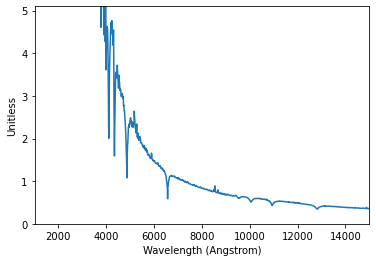

In [26]:
r = sp_LTT7987/sp_P330e_solar

r.plot(left=1000,right=15000,bottom=0.,top=5.1)

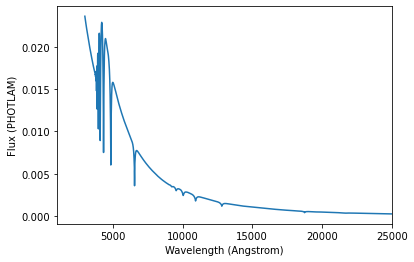

In [27]:
sp_LTT7987.plot(left=1000,right=25000)

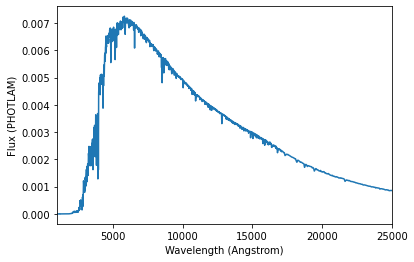

In [28]:
sp_P330e_solar.plot(left=1000,right=25000)

In [29]:
solar_hdus = fits.open("StandardStarsSpectra/p330e_stiswfcnic_003.fits")

solar_hdus[1].data

FITS_rec([(  1999.524048, 9.5861002e-17, 4.7605e-17, 9.5861000e-19,   3.092041, 1, 2046.),
          (  2001.070068, 1.0696000e-16, 4.8636e-17, 1.0696000e-18,   3.092163, 1, 2046.),
          (  2002.616211, 6.2128001e-17, 4.4634e-17, 6.2128000e-19,   3.092163, 1, 2046.),
          ...,
          (318243.21875 , 3.2126861e-20, 0.0000e+00, 6.4253723e-22, 318.125   , 1,    0.),
          (318561.59375 , 3.1997475e-20, 0.0000e+00, 6.3994946e-22, 318.375   , 1,    0.),
          (318880.3125  , 3.1866135e-20, 0.0000e+00, 6.3732267e-22, 318.71875 , 1,    0.)],
         dtype=(numpy.record, [('WAVELENGTH', '>f8'), ('FLUX', '>f4'), ('STATERROR', '>f4'), ('SYSERROR', '>f4'), ('FWHM', '>f4'), ('DATAQUAL', '>i2'), ('TOTEXP', '>f4')]))

In [30]:
u.kJy.to(new_flunit)

UnitConversionError: 'kJy' (spectral flux density) and 'erg / (Angstrom cm2 s)' (power density/spectral flux density wav) are not convertible

In [ ]:
GStab = pd.read_csv("GunnStrykerStandards/III_88_head.dat.txt",comment="#",skiprows=3,sep="|",index_col=False)

GStab = GStab.drop(index=[0,176])#.reset_index(drop=True)

GStab.columns = [i.strip(" ") for i in GStab.columns]

GStab[:30]

In [ ]:
GShdus = fits.open("GunnStrykerStandards/III_88_flux.dat.gz.fits")
GSehdus = fits.open("GunnStrykerStandards/III_88_error.dat.gz.fits")

flunit = (1E-20)*u.erg*u.s**(-1)*u.cm**(-2)*u.Hz**(-1)

new_flunit = u.erg*u.s**(-1)*u.cm**(-2)*u.Hz**(-1)


nos = np.array(list(set(GShdus[1].data["No"])))
i = 1
last_no = GShdus[1].data["No"][-1]
flux_cols = ["flux1","flux2","flux3","flux4","flux5","flux6","flux7","flux8","flux9","flux10"]

for no in nos:
    
    star_name = GStab.loc[no,"ID"].strip(    ).replace(" ","_")
    print(star_name)
    this_no, = np.where(GShdus[1].data["No"]==no)
    this_noe, = np.where(GSehdus[1].data["No"]==no)
    
    lambd_set = GShdus[1].data["lambda"][this_no]
    
    lambdas_full = []
    fluxes_full = []
    fluxes_e_full = []
    for lambd_i in range(len(lambd_set)):
        lambd = lambd_set[lambd_i]
        
        if lambd<5745:
            lambd_int = 10

        else:
            lambd_int = 20

        lambdas = np.arange(lambd,lambd+(10*lambd_int),lambd_int)
        #print(lambdas)
        if lambd == 5660:
            lambdas = []
            l = lambd
            while l<5745:
                lambdas.append(l)
                l+=10
            lambdas.append(l+20)
            lambdas = np.array(lambdas)

        fl = [(GShdus[1].data[f][this_no][lambd_i]) for f in flux_cols]#.to(new_flunit) for f in flux_cols]
        #print(len(fl),len(lambdas))
        fl = np.array([tfl*flunit.to(new_flunit).value for tfl in fl])
        #print(fl)
        fle = [(GSehdus[1].data[f][this_no][lambd_i]) for f in flux_cols]#*flunit).to(new_flunit) for f in flux_cols]
        fle = np.array([tfle*flunit.to(new_flunit).value for tfle in fle])
        
        #print(lambdas)
        lambdas_full.extend(lambdas)
        fluxes_full.extend(fl)
        fluxes_e_full.extend(fle)
    xlambda = fits.Column(name='WAVELENGTH',array=lambdas_full,format="D")
    flx = fits.Column(name="FLUX",array=fluxes_full,format="D",coord_unit="fnu")
    flx_e = fits.Column(name="ERROR",array=fluxes_e_full,format="D",coord_unit="fnu")
    
    new_bintab_name = "GunnStrykerStandards/{}_sp.fits".format(star_name)
    #print(new_bintab_name)
    new_bintab = create_new_fits_bintab(lambda_col=xlambda,flux_col=flx,err_col=flx_e,primary_hdu=GShdus[0],
                       new_fname=new_bintab_name)
    
nos

In [ ]:
sp_test = SourceSpectrum.from_file("GunnStrykerStandards/60_HER_sp.fits",flux_unit='fnu')

sp_test
print(sp_test.waverange)
sp_test_table = get_synphot_table(filters=filters,filter_file=filter_file,
                                  filters_dir=filters_directory,binrange1=1000,binrange2=55000,
                                  sp_STD=sp_test,vega=vega,area=area,filter_plot=False)

sp_test_table

In [ ]:
#... in photlam. This is the default for SourceSpectrum

print("from the original file")
print(max(sp_test(sp_test.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux u
sp_test.plot(left=100,right=30000,flux_unit='fnu')
sp_test.plot(left=100,right=30000,flux_unit='photlam')
sp_test.plot(left=100,right=30000,flux_unit='flam')
sp_test.plot(left=100,right=30000,flux_unit='Jy') #this is a Fnu-ty

#Convert the flux *arrays* from photlam to fnu, flam, fJy
sp_test_fnu=units.convert_flux(sp_test.waveset,fluxes=sp_test(sp_test.waveset),out_flux_unit = units.FNU)
sp_test_flam=units.convert_flux(sp_test.waveset,fluxes=sp_test(sp_test.waveset),out_flux_unit = units.FLAM)
sp_test_Jy=units.convert_flux(sp_test.waveset,fluxes=sp_test(sp_test.waveset),out_flux_unit = u.Jy)
#check:
print("\n from converted fluxes")
print(max(sp_test_fnu))
print(max(sp_test_flam))
print(max(sp_test_Jy))
#ok
         
#then I rebuild the spectra with these these values
sp_test_fnu=SourceSpectrum(Empirical1D,points=sp_test.waveset,lookup_table=sp_test_fnu)
sp_test_flam=SourceSpectrum(Empirical1D,points=sp_test.waveset,lookup_table=sp_test_flam)
sp_test_Jy=SourceSpectrum(Empirical1D,points=sp_test.waveset,lookup_table=sp_test_Jy)

# and create synphot spectra that have the right flux units.
sp_test_fnu=sp_test_fnu(sp_test.waveset,flux_unit=units.FNU)
sp_test_flam=sp_test_flam(sp_test.waveset,flux_unit=units.FLAM)
sp_test_Jy=sp_test_Jy(sp_test.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good p
#these objects, pretty bad.
#check:
print("\n from the rebuilt spectra")
print(max(sp_test_fnu))
print(max(sp_test_flam))
print(max(sp_test_Jy))

In [ ]:
sp_test.plot(left=3000,right=15000,flux_unit="kJy")

In [ ]:
sp_test_fnu=SourceSpectrum(Empirical1D,points=sp_test.waveset,lookup_table=sp_test_fnu)

r = sp_test/sp_test_flam

In [ ]:
sp_test_fnu.plot(flux_unit="fnu")

In [ ]:
sp_test.model#.plot(flux_unit="fnu")

In [ ]:
sp_test.plot(flux_unit="fnu")

In [ ]:
sp_test_fnu.plot(flux_unit="fnu")

In [ ]:
import synphot_routines as SYNRou
import importlib
importlib.reload(SYNRou)


sp_LTT3218=SourceSpectrum.from_file(new_fname_list[1],flux_unit='flam')

LTT3218_table, obs_filters, vega_filters = SYNRou.get_synphot_table(filters=filters,filter_file=filter_file,filters_dir=filters_directory,
                              sp_STD=sp_LTT3218,vega=vega,area=area,filter_plot=False)



LTT3218_table

In [ ]:
obs_filters[0].plot()

In [ ]:
bp=SpectralElement.from_file(filters_directory+'/'+filter_file[0])
#bp.waveset#.to(u.angstrom)
#print(bp.waveset.shape)
#convoluted way to change the wl units from micron to A. There must
wl=bp.waveset*1E1
print(wl)
#print(wl.shape)
th = bp.model.lookup_table
#print(th.shape)
Filter=SpectralElement(Empirical1D,points=wl,lookup_table=th,keep_neg=True)
binrange1 = 1000
binrange2 = 50000

Filter.plot(left=binrange1, right=binrange2,title=filter_file[0])

binset=range(binrange1,binrange2+1)

#print(binset,wl)
obs_STD_Filter=Observation(sp_test,Filter,binset=binset,force='taper')

print(obs_STD_Filter.waveset.shape)
binflux=obs_STD_Filter.sample_binned(flux_unit='count',area=area)
# Sample the "native" flux for comparison                                           
flux=obs_STD_Filter(binset,flux_unit='count',area=area)
print(flux.shape)


flux

In [ ]:
plt.plot(binflux)

In [ ]:
obs_STD_Filter.plot(left=1000,right=30000,flux_unit="kJy")

In [ ]:
sp_test.plot(left=1000,right=30000,flux_unit="kJy")

In [ ]:
r = obsspec/sp_test_fnu

r.plot()

In [ ]:
plt.plot(binflux)